### Practice Activity 7.2: Penalized Regression

Elizabeth Berry

11/10/23

In [50]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

In [51]:
# Read the data
ames = pd.read_csv("/Users/elleberry/Desktop/Classes/MBA/GSB 544 - Computing and Machine Learning/Data/AmesHousing.csv")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()
ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900


#### Part 1: Ridge Regression

In [52]:
X = ames.drop(["SalePrice", "Order", "PID"], axis=1)
y = ames["SalePrice"]

# Preprocessing
ct = ColumnTransformer(
        [
            ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
             make_column_selector(dtype_include=object)),
            ("standardize", StandardScaler(),
             make_column_selector(dtype_include=np.number))
        ],
        remainder="passthrough"
    )

In [53]:
# Pipeline for RR
ridge_pipeline = Pipeline([
    ("preprocessing", ct),
    ("ridge_regression", Ridge(alpha=1))
])

In [54]:
# Cross-validate the Ridge Regression pipeline
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_rmse_scores = -ridge_scores

In [55]:
# Comparison to ordinary linear regression (OLS)
linear_regression_pipeline = Pipeline([
    ("preprocessing", ct),
    ("linear_regression", LinearRegression())
])

linear_scores = cross_val_score(linear_regression_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
linear_rmse_scores = -linear_scores

print("Ridge Regression RMSE:", ridge_rmse_scores.mean())
print("Linear Regression RMSE:", linear_rmse_scores.mean())

Ridge Regression RMSE: 883643360.1138737
Linear Regression RMSE: 1.0646280262885696e+32


In [72]:
ridge_pipeline.fit(X, y)
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_
linear_regression_pipeline.fit(X, y)
linear_coefs = linear_regression_pipeline.named_steps['linear_regression'].coef_

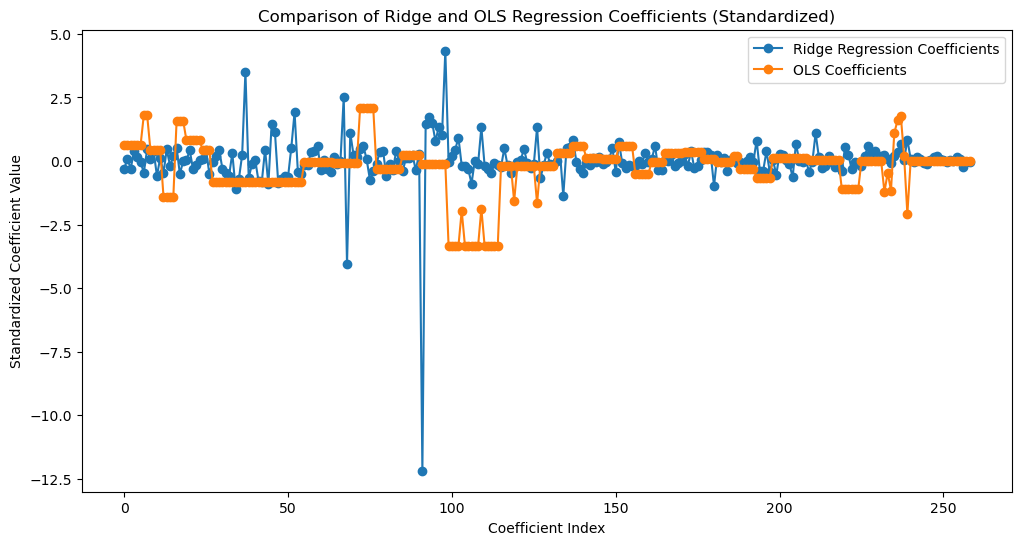

In [81]:
import matplotlib.pyplot as plt

# Standardize coefficients
ridge_coefs_standardized = ridge_coefs / np.std(ridge_coefs)
linear_coefs_standardized = linear_coefs / np.std(linear_coefs)

# Plot for comparison with RR, LASSO, and OLS
plt.figure(figsize=(12, 6))
plt.plot(ridge_coefs_standardized, marker='o', label='Ridge Regression Coefficients')
plt.plot(linear_coefs_standardized, marker='o', label='OLS Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Standardized Coefficient Value')
plt.legend()
plt.title('Comparison of Ridge and OLS Regression Coefficients (Standardized)')
plt.show()

#### Part 2: Tuning

In [58]:
# Pipeline for RR testing different alphas (log scale)
ridge_pipeline = Pipeline([
    ("preprocessing", ct),
    ("ridge_regression", Ridge())
])

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

param_grid = {'ridge_regression__alpha': alphas}
grid_search = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

best_alpha = grid_search.best_params_['ridge_regression__alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [59]:
# Get the best Ridge Regression model from the grid search
best_ridge_model = grid_search.best_estimator_

# Cross-validate the best Ridge Regression model
best_ridge_scores = cross_val_score(best_ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
best_ridge_rmse = np.sqrt(-best_ridge_scores.mean())

# Print the results
print("Best Ridge Regression RMSE:", best_ridge_rmse)

Best Ridge Regression RMSE: 29512.840095318028


#### Part 3: LASSO

In [60]:
# LASSO pipeline
lasso_pipeline = Pipeline([
    ("preprocessing", ct),
    ("lasso_regression", Lasso())
])

alphas = [0.001, 0.01, 0.1, 1, 10, 100]

param_grid_lasso = {'lasso_regression__alpha': alphas}
lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid_search.fit(X, y)

best_alpha_lasso = lasso_grid_search.best_params_['lasso_regression__alpha']
print(f"Best alpha for LASSO: {best_alpha_lasso}")

/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(
/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e+11, tolerance: 1.407e+09
  model = cd_fast.enet_coordinate_descent(
/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Best alpha for LASSO: 100


In [61]:
# Best LASSO model from grid search
best_lasso_model = lasso_grid_search.best_estimator_

best_lasso_scores = cross_val_score(best_lasso_model, X, y, cv=5, scoring='neg_mean_squared_error')
best_lasso_rmse = np.sqrt(-best_lasso_scores.mean())

print("Best LASSO Regression RMSE:", best_lasso_rmse)

Best LASSO Regression RMSE: 29223.537968311615


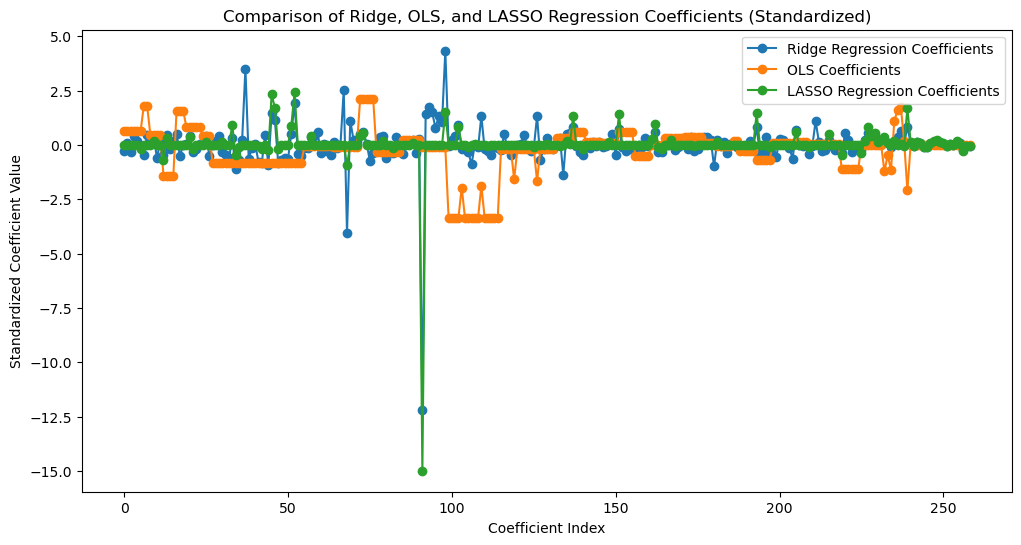

In [80]:
best_lasso_model.fit(X, y)
lasso_coefs = best_lasso_model.named_steps['lasso_regression'].coef_

# Standardize coefficients because OLS coefs are much larger and makes RR appear to be 0 unless standardized
ridge_coefs_standardized = ridge_coefs / np.std(ridge_coefs)
linear_coefs_standardized = linear_coefs / np.std(linear_coefs)
lasso_coefs_standardized = lasso_coefs / np.std(lasso_coefs)

# Plot for comparison with RR, LASSO, and OLS
plt.figure(figsize=(12, 6))
plt.plot(ridge_coefs_standardized, marker='o', label='Ridge Regression Coefficients')
plt.plot(linear_coefs_standardized, marker='o', label='OLS Coefficients')
plt.plot(lasso_coefs_standardized, marker='o', label='LASSO Regression Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Standardized Coefficient Value')
plt.legend()
plt.title('Comparison of Ridge, OLS, and LASSO Regression Coefficients (Standardized)')
plt.show()

#### Part 4: Elastic Net

In [63]:
# Elastic Net pipeline
elastic_net_pipeline = Pipeline([
    ("preprocessing", ct),
    ("elastic_net", ElasticNet())
])

alphas = [0.001, 0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

param_grid = {'elastic_net__alpha': alphas, 'elastic_net__l1_ratio': l1_ratios}
elastic_net_grid_search = GridSearchCV(elastic_net_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

elastic_net_grid_search.fit(X, y)

# Best hyperparameters
best_alpha_elastic_net = elastic_net_grid_search.best_params_['elastic_net__alpha']
best_l1_ratio_elastic_net = elastic_net_grid_search.best_params_['elastic_net__l1_ratio']
print(f"Best alpha for Elastic Net: {best_alpha_elastic_net}")
print(f"Best l1_ratio for Elastic Net: {best_l1_ratio_elastic_net}")

/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.058e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(
/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.003e+11, tolerance: 1.463e+09
  model = cd_fast.enet_coordinate_descent(
/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Best alpha for Elastic Net: 0.01
Best l1_ratio for Elastic Net: 0.7


/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.050e+11, tolerance: 1.793e+09
  model = cd_fast.enet_coordinate_descent(


In [64]:
best_elastic_net_model = elastic_net_grid_search.best_estimator_

best_elastic_net_scores = cross_val_score(best_elastic_net_model, X, y, cv=5, scoring='neg_mean_squared_error')
best_elastic_net_rmse = np.sqrt(-best_elastic_net_scores.mean())

print("Best Elastic Net RMSE:", best_elastic_net_rmse)

/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.250e+11, tolerance: 1.348e+09
  model = cd_fast.enet_coordinate_descent(
/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.967e+11, tolerance: 1.474e+09
  model = cd_fast.enet_coordinate_descent(
/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

Best Elastic Net RMSE: 29515.534050339702


/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.917e+11, tolerance: 1.477e+09
  model = cd_fast.enet_coordinate_descent(


/Users/elleberry/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.050e+11, tolerance: 1.793e+09
  model = cd_fast.enet_coordinate_descent(


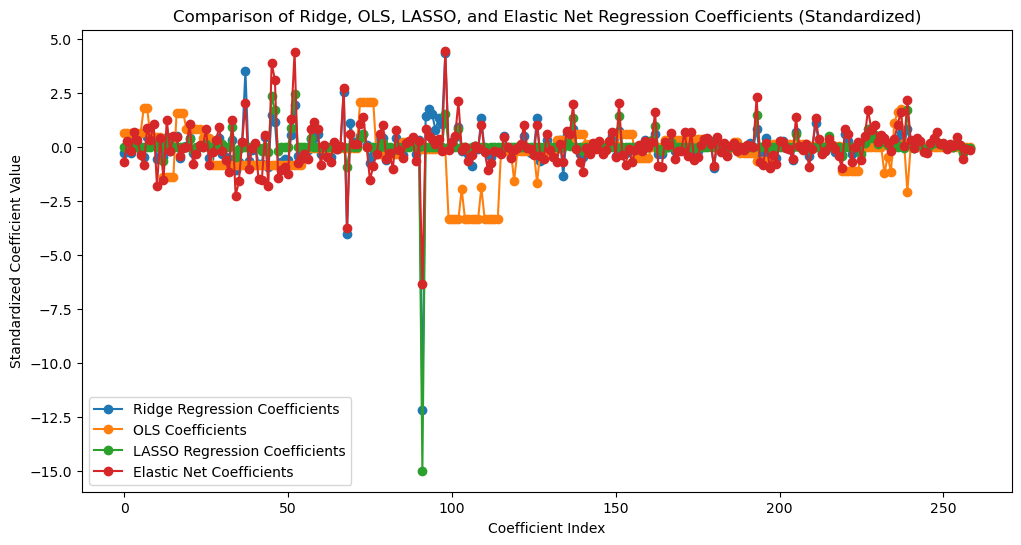

In [77]:
best_elastic_net_model.fit(X, y)

elastic_net_coefs = best_elastic_net_model.named_steps['elastic_net'].coef_

# Standardize coefficients
ridge_coefs_standardized = ridge_coefs / np.std(ridge_coefs)
linear_coefs_standardized = linear_coefs / np.std(linear_coefs)
lasso_coefs_standardized = lasso_coefs / np.std(lasso_coefs)
elastic_net_coefs_standardized = elastic_net_coefs / np.std(elastic_net_coefs)

# Plot for comparison with RR, LASSO, and OLS
plt.figure(figsize=(12, 6))
plt.plot(ridge_coefs_standardized, marker='o', label='Ridge Regression Coefficients')
plt.plot(linear_coefs_standardized, marker='o', label='OLS Coefficients')
plt.plot(lasso_coefs_standardized, marker='o', label='LASSO Regression Coefficients')
plt.plot(elastic_net_coefs_standardized, marker='o', label='Elastic Net Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Standardized Coefficient Value')
plt.legend()
plt.title('Comparison of Ridge, OLS, LASSO, and Elastic Net Regression Coefficients (Standardized)')
plt.show()